# Hierarchical Models

##### Keywords: hierarchical, bayesian, empirical bayes, rat tumors, partial pooling,  kidney cancer,  type-2 MLE, exchangeability, beta, binomial, beta-binomial

In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')

## Summary

Hierarchical models enable us to use gibbs sampling and priors which learn from data. We see how to set up such models using Gelman's rat tumors example. In this fashion statistically weak units such as low sample size experiments can be regularized towards the prior. 

Such shrinkage is observed both when the aproximate Empirical Bayes methodology is used to estimate the prior's parameters (hyper-parameters), and when we do a full bayesian analysis by putting weakly informative hyper-priors on the hyper-parameters. The exact mechanism of setting up the hierarchy in the model depends on the exchangeability of units in our analysis, but once we set it up, conditionals simply involve sampling from parents.

---

## Contents
{:.no_toc}
* 
{: toc}

## An Example: Rats tumors (from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5)


The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

In [3]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [4]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory, tumorn            

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

Now, a 71st experiment is done and we are told that 4 out of 14 rats develop tumors. Our problem is  to estimate the risk of tumor in the rats in the 71st experiment .

Thus we are considering the problem of estimating the tumor rate from a small experiment (no 71) and a prior constructed from previous experiments with similar structure. Mathematically, we consider the current and historical experiments as random samples from a common population.

In [7]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

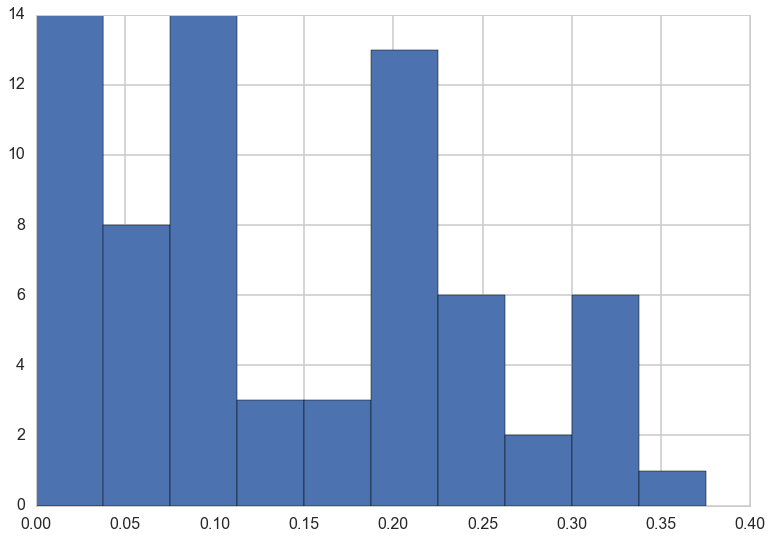

In [10]:
plt.hist(tumor_rat);

## Setting up the model


In the $j$-th historical experiment, let the number of rats with tumors be $y_j$ and the total number of rats be $n_j$.
Since the rats either have or dont have the tumor, it makes sense to use a Binomial Model for **each** experiment, assuming a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments

$$p(y_i|\theta_i; n_i) =  Binom(n_i, y_i, \theta_i) $$

and for all the data we have, using $Y=[y_1,\ldots, y_{70}]$ and $\Theta = [\theta_1, \ldots, \theta_{70}]$ and I use the notation
$\{n_i\} =[n_1, \ldots, n_{70}]$

$$ p(Y|\Theta; \{n_i\}) =  \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i) $$

We now need to choose a prior $p(\Theta)$. 

### No Pooling

Our first thought might be to use a Beta (conjugate prior to Binomial) for each $\theta_i$, i.e.

$$ \theta_i \sim Beta(\alpha_i, \beta_i).$$

$$p(\Theta| \{\alpha_i\}, \{\beta_i\}) = \prod_{i=1}^{70} Beta(\theta_i, \alpha_{i}, \beta_{i}),$$

where $\alpha_i$ and $\beta_i$ are what we called **hyperparameters**. Again I use the notation $\{\alpha_i\}=[\alpha_1, \ldots, \alpha_{70} ]$ and similarly for $\{beta\}$.

However, we would then come up with a very overfit model with 210 parameters and not much data. Besides, there are likely outliers in some experiments, small sample sizes, etc.

In your standard bias-variance tradeoff view of things this is a  model with a large amount of variance.

### Full pooling

The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance. Thus such a model might thus be underfit, unable to capture the variations in the samples. This is likely a model with a large amount of variance

## Partial pooling and the hierarchical model

Let us compromise and assume that the $\theta_i$s are drawn from a "population distribution" given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$ \theta_i \sim Beta(\alpha, \beta).$$


$$p(\Theta | \alpha, \beta) = \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta).$$

This structure is shown in the diagram below.

![](images/rat-tumor-hier2.png)

(image from http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf)

Such a model is called a **hierarchical** model, with observable outcomes modeled conditionally on certain parameters($\theta$s) which themselves are given a probabilistic specification in terms of further parameters ($\alpha$ and $\beta$), known as **hyperparameters**.



###  Priors from data

Now, to complete the story, we need to ask, where do $\alpha$ and $\beta$ come from? Why are we calling them hyperparameters? So far, in all the bayesian models we have created, we have assumed known values of the "hyperparameters" in the priors. The criteria for the values we have used have been to create either uninformative or weakly-informative(weakly-regularizing) priors.

Now we wish to estimate the parameters of these priors themselves from the data. This seems to contravene the Bayesian idea. Why would we want to do this?

The key idea here is that some of our **units** (experiments in our example) are statistically more robust than others. The non-robust experiments may have smaller samples or outlier like behavior, for example. What we wish to do is to borrow strength from all the data as a whole through the estimation of the hyperparameters. In this sense, our procedure will help us create a **regularized partial pooling model** in which the "lower level" (closer to data) parameter ($\theta$s) estimations are tied together by "upper level" parameters.

## Another example: kidney cancer

Another example comes from kidney cancer rates across counties in the US. Here is a  map of counties with the highest kidney cancer rated in blue and the lowest kidney cancer rates in red:

![](images/kidneycancerus.png)

If you plot the rates against the population of the counties it gives away the story: 

![](images/kidneycanceruspop.png)

It is hard to estimate rates in counties with low populations. 1 case maybe a rate too low or a rate too high.

Here hierarchical models can also come to the rescue! By assuming that the rates are drawn from a common prior distribution with hyperparameters somehow estimated using all the data, we borrow statistical strength from more populated counties and give it to less populated counties, thus regularizing their rate estimates.

## Empirical Bayes

Our first idea to this is to simply estimate these hyperparameters ($\alpha$ and $\beta$) directly from the data. The idea here is simple. We find the posterior-predictive distribution, as a function of these upper level parameters. Lets call these parameters $\eta$ (in our case $\eta = (\alpha, \beta)$).

Then, for some "new" data $y^*$:

$$p(y^* \vert  D, \eta) = \int d\theta \, p(y^* \vert \theta) \, p(\theta \vert D, \eta)$$

We notice that this looks like a likelihood with parameters $\eta$ and simply use maximum-likelihood with respect to $\eta$ to estimate these $\eta$ using our "data" $y^*$. But note that, unlike in cross-validation in machine learning, where we have already determined $\theta$ on the training set, we have not determined $\theta$ yet here. Indeed, instead of optimizing  on $\theta$, we have marginalized over them. So we can do the optimization to find $\eta$ directly on our training set, or sample, itself.

This method is called **Emprical Bayes** or **Type-2 Maximum Likelihood**.

In practice, we often match moments of the hyperparameter likelihood with our data. In our example, there are two parameters $\alpha$ and $\beta$ to be estimated. By computing the mean and the variance of the type-2 likelihood (the posterior predictive as a function of the hyperparameters) we can solve for both $\alpha$ and $\beta$. Sometimes we will use the prior instead: it depends on the meaning of either distribution.

### Empirical Bayes rat tumors

![](images/ratsempbayes.png)

(image from http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf)

We'll insert point estimates from the method of moments, used on the prior distribution. Since the prior  is the beta distribution, we need to find the mean and variance of it:

$$\mu =  \frac{\alpha}{\alpha + \beta}$$

and

$$V  = \frac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$$

Note that there are different ratios for each experiment, and we are taking the average of these.

In [11]:
aplusb = tmean*(1-tmean)/tvar - 1
a_est=aplusb*tmean
b_est=aplusb*(1.0 - tmean)
a_est, b_est

(1.3777748392916778, 8.7524354471531129)

We can now use these to compute the posterior means for all the experiments.

The conditional posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$ 

Thus the posterior mean is

$$\bar{\theta}_{post, i} = \frac{\alpha + y_i}{\alpha + \beta + n_i}$$

In [12]:
post_means = (a_est + tumory)/(a_est + b_est + tumorn)

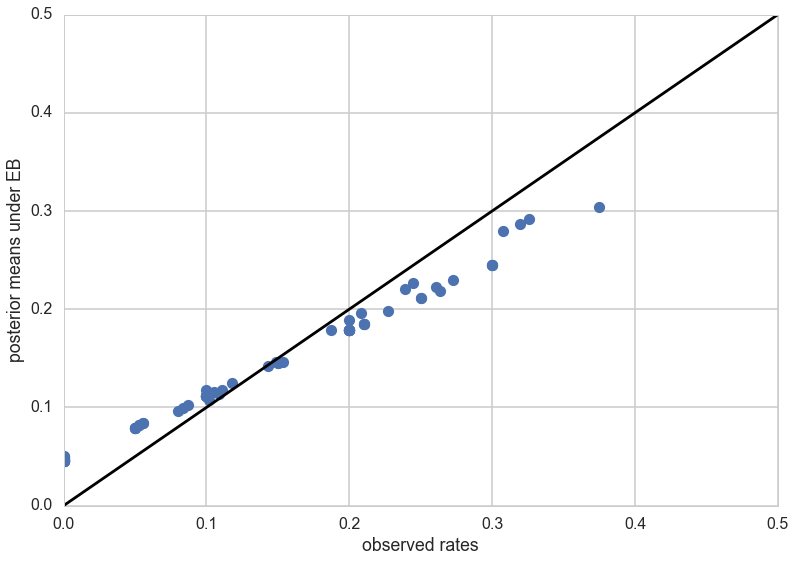

In [13]:
plt.plot(tumor_rat, post_means,'o')
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior means under EB");

As you can see, the posterior rates are shrunk towards flatness, which would correspond to complete pooling. The 45 degree line would be for completely unpooled estimate.

Now, for the 71st experiment, we have 4 out of 14 rats having tumors. The posterior estimate for this would be

$$\frac{\alpha + y_{71}}{\alpha + \beta + n_{71}}$$

In [15]:
4/14, (4+a_est)/(14+a_est+b_est)

(0.2857142857142857, 0.22286481449822493)

So we would revise our estimate downwards for this experiment.

## A fully Bayesian treatment

Empirical bayes seems a nice procedure, but suffers from the problem that one is still carrying out an optimization, even if with respect to the hyperparameters $\eta$. And every optimization is a chance to overfit. 

What we would like to do is to use integration all the way.

To do that we need to specify a **hyper-prior** $p(\eta)$ ($p(\alpha, \beta)$) on these hyperparameters $\eta$ ($\alpha, \beta$). The idea of the hyper-prior is the same as that of a prior; except that the hyperpriors are priors on prior parameters.  In other words, we have pushed things one level up in the hierarchy.

We could go turtles all the way and create hyper-hyper-priors on the hyper-hyper-parameters of the hyper-prior. However , we typically use **uninformative hyperpriors** instead: indeed this is one of the key strategies of hierarchical modelling: un-informative priors are pushed down the prior hierarchy.

Modeling in this way has two advantages: (a) as we shall see, it helps us develop a computational strategy to solve the problem which naturally relies on the structure of gibbs sampling, and (b) similar to empirical-bayes, it allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the finding of posterior distributions on the hyperparameters, instead of just fitting for them. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps **regularize** this, with the additional smearing from the hyper-parameter posteriors mitigating any overfitting.

### Fully Bayesian rat tumors

We write out a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$.

$$p( \theta_i, \alpha, \beta | y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i | \alpha, \beta) \, p(y_i | \theta_i, n_i,\alpha, \beta)$$

or for the whole dataset:

$$ p( \Theta, \alpha, \beta | Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

The conditional posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$ 


For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha | Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta | Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

Now notice something: if $\alpha$ and $\beta$ are fixed I cn easily sample from any of the 70 $\theta_i$s. And I can do this in order. Thus we have a  Gibbs step for the $\theta_i$s.

The sampling for $\alpha$ and $\beta$ is a bit more complex. From the expressions, its clear that these do not split out in a simple fashion, leaving us known distributions that would allow for straightforward gibbs sampling. But we can use metropolis steps with normal proposals for both. So, when we sample for $\alpha$, we will propose a new value using a normal proposal, while holding all the $\theta$s and $\beta$ constant at the old value.

We will write the sampler for this model in lab.

##  Why are hierarchical models useful?

Hierarchical models provide a simple way to organize inference into a directed acyclic graph, with the observations layer at the bottom of a tree, the next layer being the intermediate parameters, and the upper layers being the hyper-parameters, as we have seen above. This graph structure allows us to sample conditionals easily.

When we are sampling up the graph, a node depends only on its parents all the way to the root.  So, to sample a $y_5$ (predictive)  one needs only $\theta_5$, $\alpha$, and $\beta$, and nothing else. This structure allows one to factorize a simple conditional structure and use a gibbs sampler upwards. When trying to go downwards, all we need to do is to use metropolis or metropolis hastings steps in a componentwise fashion.

Gibbs is easiest to use when one can directly sample from a conditional, as in the case of the $\theta$s. But once stationarity has been reached, one can always sample using MH from a non-simple-to-sample conditional. This makes Gibbs very generally applicable and is the basis for software packages such as BUGS and JAGS.

(one could combine multiple components into a block if it made sense..for example, to sample from a 3D gaussian one could alternatively sample from a 1-D gaussian and a 2-D gaussian).

In the case that we can use conjugacy like we did above, this simplifies even further, because the draws then are from members of the exponential family for which sampling is well established.

Hierarchical modelling also provides us a disciplined way to think about exchangeability in modelling, which is very important to understand as it guides us in setting up models correctly.


### Exchangeability

The iid assumption in statistics is an assumption that the values $y_i$ that go into a density (or likelihood) are **exchangeable**. That is, the likelihood is invariant to the permutation of data indices. If one has covariates, we are then talking about the joint density $p(x,y)$ or $p(x,y \vert \theta)$ and it is $(x,y)$ thats assumed to be the unit of permutation. 

In practice, ignorance implies exchangeability. Maximal exchangeability is indeed the argument underlying maximum entropy.

In hierarchical models, we use the notion of exchangeability at the level of 'units'. By units we mean an observationally cohesive bunch of data. For example, our unit may be observations in a particular experiment, and then hierarchically, we might talk about exchangeability between different experiments. For our rats, the $y_j$ were exchangeable since we had no additional information about experimental conditions. But if we knew that specific groups of experiments came from specific laboratories, we would now only assume partial exchangeability. We'd assume that experiments were interchangeable if they came from the same lab. So then we'd have lab specific $\alpha$ and $\beta$ parameters, and add another level of hierarchy to figure how these might themselves be drawn from some common distribution.